In [25]:
import numpy as np
import pandas as pd

from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.cluster import KMeans

from doc.mse_estimator import ErrorComparer
from doc.data_generation import gen_rbf_X, gen_matern_X, create_clus_split, gen_cov_mat

import matplotlib.pyplot as plt

from tqdm import tqdm

## Setup

In [86]:
np.random.seed(1)

In [87]:
nx = 50
ny = 50

n = nx * ny
p = 30
s = 30

In [88]:
xs = np.linspace(0, 25, nx)
ys = np.linspace(0, 25, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [89]:
Sigma = gen_cov_mat(c_x, c_y, RBF(length_scale=5.))
Chol = np.linalg.cholesky(Sigma + .1*np.eye(n))

## Generate Gaussian X, Y

In [90]:
(Chol[0,0] * Chol[:,0])[:20]

array([1.1       , 0.99480736, 0.97939068, 0.9542253 , 0.92007635,
       0.87796012, 0.82909386, 0.77483743, 0.71663079, 0.65593125,
       0.59415419, 0.53262064, 0.47251413, 0.41484856, 0.36044779,
       0.30993678, 0.26374356, 0.22211024, 0.18511146, 0.15267783])

In [91]:
X = gen_rbf_X(c_x, c_y, p)
# X = gen_matern_X(c_x, c_y, p, length_scale=1, nu=1)
# X = np.random.randn(n,p)

beta = np.zeros(p)
idx = np.random.choice(p,size=s)
beta[idx] = np.random.uniform(-1,1,size=s)

In [92]:
Y = X @ beta + Chol @ np.random.randn(n)

## Compute expected correction for one fold of CV vs expected correction for random sample

In [93]:
## assuming linear model, and bias approx 0
def computeCorrection(
    S, 
    Sigma, 
    tr_idx, 
    ts_idx=None,
):
    if ts_idx is None:
        ts_idx = ~tr_idx

    return (Sigma[ts_idx,ts_idx].sum() - 2*np.diag(S @ Sigma[tr_idx,:][:,ts_idx]).sum()) / ts_idx.sum()

In [94]:
def getDistance(c_x, c_y):
    Loc = np.stack([c_x, c_y]).T
    m = np.sum(Loc**2, axis=1)
    D = (-2 * Loc.dot(Loc.T) + m).T + m
    D = 0.5 * (D + D.T)
    D = np.maximum(D, 0)  ## sometimes gets values like -1e-9
    D = np.sqrt(D)
    
    return D    

def getBufferTrain(D, tr_bool, ts_idx):
    buffer_tr_bool = tr_bool & (D[ts_idx,:] > 20)
    return buffer_tr_bool

In [95]:
D = getDistance(c_x, c_y)

In [96]:
kfcv_corr = np.zeros(100)
spcv_corr = np.zeros(100)
bloocv_corr = np.zeros(100)
ns_corr = np.zeros(100)
sp_corr = np.zeros(100)

for i in tqdm(range(100)):
    idxs = np.random.choice(n, size=int(.3*n), replace=False)
    cv_tr_idx = idxs[:int(.1*n)]
    cv_tr_bool = np.zeros(n, dtype=bool)
    cv_tr_bool[cv_tr_idx] = True

    cv_ts_idx = idxs[int(.1*n):int(.2*n)]
    cv_ts_bool = np.zeros(n, dtype=bool)
    cv_ts_bool[cv_ts_idx] = True

    tr_idx = idxs[:int(.2*n)]
    tr_bool = np.zeros(n, dtype=bool)
    tr_bool[tr_idx] = True

    ts_idx = idxs[int(.2*n):]
    ts_bool = np.zeros(n, dtype=bool)
    ts_bool[ts_idx] = True

    ## split into 3 folds by kmeans
    groups = KMeans(n_init=10, n_clusters=5).fit(coord[idxs]).labels_
    spcv_tr_idx = idxs[np.where(groups < 4)[0]]
    spcv_tr_bool = np.zeros(n, dtype=bool)
    spcv_tr_bool[spcv_tr_idx] = True
    spcv_ts_idx = idxs[np.where(groups == 4)[0]]
    spcv_ts_bool = np.zeros(n, dtype=bool)
    spcv_ts_bool[spcv_ts_idx] = True

    ## pick one point for ts, tr is all far enough away
    bloocv_tr_idx = idxs[np.random.choice(len(idxs),size=len(idxs),replace=False)]
    bloocv_ts_idx = bloocv_tr_idx[0]

    bloocv_tr_bool = np.zeros(n, dtype=bool)
    bloocv_tr_bool[bloocv_tr_idx] = True
    bloocv_tr_bool = getBufferTrain(D, bloocv_tr_bool, bloocv_ts_idx)

    bloocv_ts_bool = np.zeros(n, dtype=bool)
    bloocv_ts_bool[bloocv_ts_idx] = True

    X = gen_rbf_X(c_x, c_y, p)
    Y = X@beta + Chol @ np.random.randn(n)
    
    X_cv = X[cv_tr_idx,:]
    S_cv = X[cv_ts_idx,:] @ np.linalg.pinv(X_cv)

    X_spcv = X[spcv_tr_idx,:]
    S_spcv = X[spcv_ts_idx,:] @ np.linalg.pinv(X_spcv)

    X_bloocv = X[bloocv_tr_bool,:]
    S_bloocv = X[bloocv_ts_idx,:] @ np.linalg.pinv(X_bloocv)

    
    X_tr = X[tr_idx,:]
    S_tr = X[ts_idx,:] @ np.linalg.pinv(X_tr)

    sp_idx = np.random.choice(ts_idx,size=1)
    sp_bool = np.zeros(n, dtype=bool)
    sp_bool[sp_idx] = True
    S_sp = X[sp_idx,:] @ np.linalg.pinv(X_tr)
    kfcv_corr[i] = computeCorrection(S_cv, Sigma, cv_tr_bool, cv_ts_bool)
    spcv_corr[i] = computeCorrection(S_spcv, Sigma, spcv_tr_bool, spcv_ts_bool)
    bloocv_corr[i] = computeCorrection(S_bloocv, Sigma, bloocv_tr_bool, bloocv_ts_bool)
    ns_corr[i] = computeCorrection(S_tr, Sigma, tr_bool, ts_bool)
    sp_corr[i] = computeCorrection(S_sp, Sigma, tr_bool, sp_bool)
    
corrs = pd.DataFrame({
    'KFCV': kfcv_corr, 
    'SPCV': spcv_corr, 
    'BLOOCV': bloocv_corr, 
    'NewSampleErr':ns_corr, 
    'SinglePointErr': sp_corr
})


100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


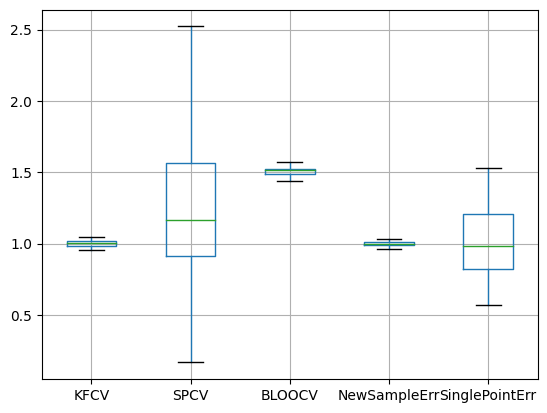

In [97]:
(corrs / ns_corr.mean()).boxplot(showfliers=False)
plt.show()

In [98]:
(corrs / ns_corr.mean()).mean()

KFCV              1.002903
SPCV              1.276507
BLOOCV            1.477556
NewSampleErr      1.000000
SinglePointErr    1.015279
dtype: float64

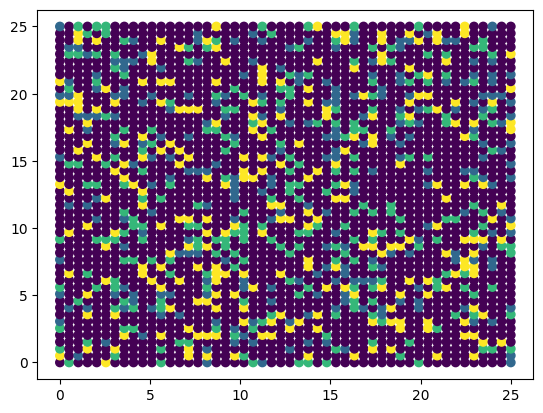

In [99]:
# %matplotlib notebook
plt.scatter(
    c_x, 
    c_y, 
    c=cv_tr_bool+ 2*cv_ts_bool + 3*ts_bool, 
    label=cv_tr_bool+ 2*cv_ts_bool + 3*ts_bool
)
plt.show()

## Compute expected correction for one fold of CV vs expected correction for clustered sample

In [100]:
clus_kfcv_corr = np.zeros(100)
clus_spcv_corr = np.zeros(100)
clus_bloocv_corr = np.zeros(100)
clus_ns_corr = np.zeros(100)
clus_sp_corr = np.zeros(100)

for i in tqdm(range(100)):
    idxs, ts_idx = create_clus_split(
        nx,
        ny,
        .2,
        ngrid=10,
        ts_frac=.1,
        sort_grids=True,
    )
    ## randomize order for CV
    idxs = np.random.choice(idxs, size=len(idxs), replace=False)

    cv_tr_idx = idxs[:np.round(len(idxs)/2).astype(int)]
    cv_tr_bool = np.zeros(n, dtype=bool)
    cv_tr_bool[cv_tr_idx] = True

    cv_ts_idx = idxs[np.round(len(idxs)/2).astype(int):]#int(.4*n)]
    cv_ts_bool = np.zeros(n, dtype=bool)
    cv_ts_bool[cv_ts_idx] = True

    tr_idx = idxs#[:int(.4*n)]
    tr_bool = np.zeros(n, dtype=bool)
    tr_bool[tr_idx] = True

    # ts_idx = np.random.choice(not_test_idxs, size=int(.2*n), replace=False)
    ts_bool = np.zeros(n, dtype=bool)
    ts_bool[ts_idx] = True


    ## split into 3 folds by kmeans
    groups = KMeans(n_init=10, n_clusters=5).fit(coord[idxs]).labels_
    spcv_tr_idx = idxs[np.where(groups < 4)[0]]
    spcv_tr_bool = np.zeros(n, dtype=bool)
    spcv_tr_bool[spcv_tr_idx] = True
    spcv_ts_idx = idxs[np.where(groups == 4)[0]]
    spcv_ts_bool = np.zeros(n, dtype=bool)
    spcv_ts_bool[spcv_ts_idx] = True

    ## pick one point for ts, tr is all far enough away
    bloocv_tr_idx = idxs[np.random.choice(len(idxs),size=len(idxs),replace=False)]
    bloocv_ts_idx = bloocv_tr_idx[0]

    bloocv_tr_bool = np.zeros(n, dtype=bool)
    bloocv_tr_bool[bloocv_tr_idx] = True
    bloocv_tr_bool = getBufferTrain(D, bloocv_tr_bool, bloocv_ts_idx)

    bloocv_ts_bool = np.zeros(n, dtype=bool)
    bloocv_ts_bool[bloocv_ts_idx] = True

    X = gen_rbf_X(c_x, c_y, p)
    Y = X@beta + Chol @ np.random.randn(n)
    
    X_cv = X[cv_tr_idx,:]
    S_cv = X[cv_ts_idx,:] @ np.linalg.pinv(X_cv)

    X_spcv = X[spcv_tr_idx,:]
    S_spcv = X[spcv_ts_idx,:] @ np.linalg.pinv(X_spcv)

    X_bloocv = X[bloocv_tr_bool,:]
    S_bloocv = X[bloocv_ts_idx,:] @ np.linalg.pinv(X_bloocv)

    
    X_tr = X[tr_idx,:]
    S_tr = X[ts_idx,:] @ np.linalg.pinv(X_tr)

    sp_idx = np.random.choice(ts_idx,size=1)
    sp_bool = np.zeros(n, dtype=bool)
    sp_bool[sp_idx] = True
    S_sp = X[sp_idx,:] @ np.linalg.pinv(X_tr)
    clus_kfcv_corr[i] = computeCorrection(S_cv, Sigma, cv_tr_bool, cv_ts_bool)
    clus_spcv_corr[i] = computeCorrection(S_spcv, Sigma, spcv_tr_bool, spcv_ts_bool)
    clus_bloocv_corr[i] = computeCorrection(S_bloocv, Sigma, bloocv_tr_bool, bloocv_ts_bool)
    clus_ns_corr[i] = computeCorrection(S_tr, Sigma, tr_bool, ts_bool)
    clus_sp_corr[i] = computeCorrection(S_sp, Sigma, tr_bool, sp_bool)

    # print(ts_bool.sum(), cv_tr_bool.sum(), cv_ts_bool.sum())
    
clus_corrs = pd.DataFrame({
    'KFCV': clus_kfcv_corr, 
    'SPCV': clus_spcv_corr, 
    'BLOOCV': clus_bloocv_corr, 
    'NewSampleErr': clus_ns_corr, 
    'SinglePointErr': clus_sp_corr
})


100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


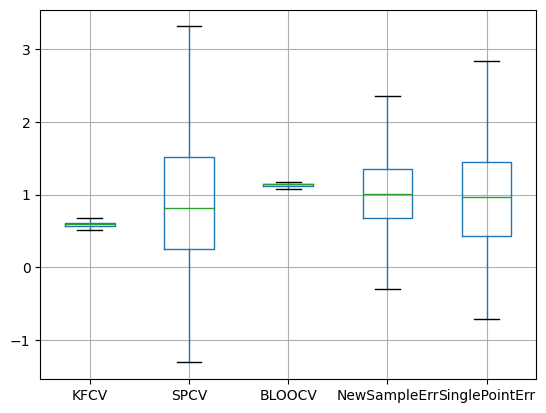

In [101]:
(clus_corrs / clus_ns_corr.mean()).boxplot(showfliers=False)
plt.show()

In [102]:
(clus_corrs / clus_ns_corr.mean()).mean()

KFCV              0.596282
SPCV              0.851665
BLOOCV            1.130728
NewSampleErr      1.000000
SinglePointErr    0.920428
dtype: float64

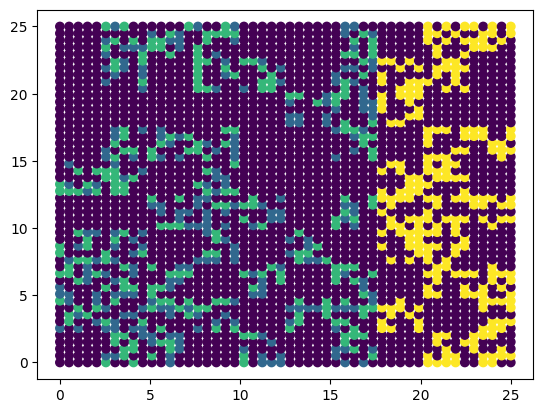

In [103]:
plt.scatter(
    c_x, 
    c_y, 
    c=cv_tr_bool+ 2*cv_ts_bool + 3*ts_bool, 
    label=cv_tr_bool+ 2*cv_ts_bool + 3*ts_bool
)
plt.show()